In [1]:
from pathlib import Path
import json, pandas as pd

REPO_ROOT = (Path.cwd().parents[1] if (Path.cwd().name == "classification" and Path.cwd().parent.name == "notebooks")
             else Path.cwd())
MET_DIR = REPO_ROOT / "results" / "metrics"

In [2]:
def show_test_json(fname):
    p = MET_DIR / fname
    obj = json.loads(p.read_text())
    print(f"Model: {obj.get('model')}")
    print(f"Test Accuracy: {obj['test_accuracy']:.4f}")
    print(f"Test Macro AUROC: {obj['test_macro_auroc']:.4f}")
    df = pd.DataFrame(obj["classification_report"]).T
    display(df)



In [3]:
# CNN
show_test_json("cls_bloodcells_resnet18_test.json")


Model: resnet18
Test Accuracy: 0.9933
Test Macro AUROC: 0.9984


,precision,recall,f1-score,support
basophil,0.993333,0.993333,0.993333,150.000000
erythroblast,1.000000,0.986667,0.993289,150.000000
monocyte,0.980392,1.000000,0.990099,150.000000
myeloblast,0.993333,0.993333,0.993333,150.000000
seg_neutrophil,1.000000,0.993333,0.996656,150.000000
accuracy,0.993333,0.993333,0.993333,0.993333
macro avg,0.993412,0.993333,0.993342,750.000000
weighted avg,0.993412,0.993333,0.993342,750.000000


In [4]:
# ViT (edit to match your vit_name)
show_test_json("cls_bloodcells_vit_tiny_patch16_224_test.json")

Model: vit_tiny_patch16_224
Test Accuracy: 0.9907
Test Macro AUROC: 0.9985


,precision,recall,f1-score,support
basophil,1.000000,0.966667,0.983051,150.000000
erythroblast,1.000000,0.993333,0.996656,150.000000
monocyte,0.961538,1.000000,0.980392,150.000000
myeloblast,0.993377,1.000000,0.996678,150.000000
seg_neutrophil,1.000000,0.993333,0.996656,150.000000
accuracy,0.990667,0.990667,0.990667,0.990667
macro avg,0.990983,0.990667,0.990686,750.000000
weighted avg,0.990983,0.990667,0.990686,750.000000


In [5]:
import pandas as pd, json

files = [
    "cls_bloodcells_resnet18_test.json",
    "cls_bloodcells_vit_tiny_patch16_224_test.json",
]

rows = []
for f in files:
    o = json.loads((MET_DIR / f).read_text())
    rows.append({"file": f, "model": o["model"], "acc": o["test_accuracy"], "macro_auroc": o["test_macro_auroc"]})
pd.DataFrame(rows).sort_values("macro_auroc", ascending=False)


,file,model,acc,macro_auroc
1,cls_bloodcells_vit_tiny_patch16_224_test.json,vit_tiny_patch16_224,0.990667,0.998526
0,cls_bloodcells_resnet18_test.json,resnet18,0.993333,0.998390


In [6]:
import numpy as np, json, torch, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torchmetrics.classification import MulticlassAUROC
from tqdm.auto import tqdm
import mplcyberpunk

plt.style.use("cyberpunk")

def plot_confusion_matrix_cyberpunk(cm, class_names, title, save_path):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap="magma"); fig.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(class_names)), labels=class_names, rotation=30, ha="right")
    ax.set_yticks(np.arange(len(class_names)), labels=class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    thresh = cm.max()/2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i,j]), ha="center", va="center",
                    color="white" if cm[i,j] > thresh else "black")
    mplcyberpunk.make_lines_glow(ax=ax)
    plt.tight_layout(); fig.savefig(save_path, dpi=150); plt.show()
    print("Saved →", save_path)

In [9]:
import torch, torch.nn as nn
from torchvision import models as tvm
import timm

def build_resnet18(num_classes: int):
    m = tvm.resnet18(weights=None)     
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_vit_tiny(num_classes: int, name="vit_tiny_patch16_224"):
    return timm.create_model(name, pretrained=False, num_classes=num_classes)


In [10]:
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt, mplcyberpunk
plt.style.use("cyberpunk")

def plot_confusion_matrix_cyberpunk(cm, class_names, title, save_path):
    import matplotlib.patheffects as pe
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap="magma"); fig.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(class_names)), labels=class_names, rotation=30, ha="right")
    ax.set_yticks(np.arange(len(class_names)), labels=class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i,j]), ha="center", va="center", color="white",
                    path_effects=[pe.withStroke(linewidth=2, foreground="black")])
    mplcyberpunk.make_lines_glow(ax=ax)
    plt.tight_layout(); fig.savefig(save_path, dpi=150); plt.show()

def test_and_report_from_ckpt(ckpt_path: Path, build_model_fn, tag: str, test_loader, device, default_class_names):
    """Rebuilds a model with the right num_classes using the checkpoint metadata, loads weights, and evaluates."""
    state = torch.load(ckpt_path, map_location=device)
    class_names = state.get("class_names", default_class_names)
    num_classes = state.get("num_classes", len(class_names))

    model = build_model_fn(num_classes).to(device)
    model.load_state_dict(state["state_dict"]); model.eval()

    # Collect predictions
    logits_list, targets_list = [], []
    with torch.no_grad():
        for x, y in tqdm(test_loader, leave=False):
            logits_list.append(model(x.to(device)).cpu())
            targets_list.append(torch.as_tensor(y))

    logits = torch.cat(logits_list)
    probs  = logits.softmax(1)
    preds  = probs.argmax(1)
    targets = torch.cat(targets_list).long()

    # Metrics
    auroc = MulticlassAUROC(num_classes=num_classes, average="macro")(probs, targets).item()
    acc   = MulticlassAccuracy(num_classes=num_classes, average="macro")(preds, targets).item()
    rep   = classification_report(targets.numpy(), preds.numpy(), target_names=class_names, digits=4)

    print(f"[{tag}]  Test Accuracy: {acc:.4f} | Macro AUROC: {auroc:.4f}\n")
    print(rep)

    # Save JSON + Confusion Matrix
    MET_DIR = REPO_ROOT / "results" / "metrics"; MET_DIR.mkdir(parents=True, exist_ok=True)
    FIG_DIR = REPO_ROOT / "results" / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

    from sklearn.metrics import classification_report as cr
    rep_dict = cr(targets.numpy(), preds.numpy(), target_names=class_names, output_dict=True)
    out_json = MET_DIR / f"{tag}_test.json"
    with open(out_json, "w") as f:
        import json; json.dump({"dataset":"bloodcells","model":tag,"num_classes":num_classes,
                                "test_macro_auroc": auroc, "test_accuracy": acc,
                                "classification_report": rep_dict}, f, indent=2)
    print("Saved →", out_json)

    cm = confusion_matrix(targets.numpy(), preds.numpy())
    plot_confusion_matrix_cyberpunk(cm, class_names, f"Bloodcells • {tag} Confusion Matrix",
                                    FIG_DIR / f"{tag}_confusion_matrix.png")


In [13]:
from pathlib import Path
import json, pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

# repo/split paths
REPO_ROOT = Path.cwd().parents[1] if (Path.cwd().name == "classification" and Path.cwd().parent.name == "notebooks") else Path.cwd()
SPLIT_DIR = REPO_ROOT / "data" / "processed" / "classification" / "blood_cell_images_for_cancer_detection_processed" / "splits" / "fold0"

# labels
with open(SPLIT_DIR / "label_map.json") as f:
    label_map = {int(k): v for k, v in json.load(f).items()}
class_names = [label_map[i] for i in sorted(label_map)]
num_classes = len(class_names)

# simple val transforms (224 crop, ImageNet norm)
mean, std = [0.485,0.456,0.406], [0.229,0.224,0.225]
from torchvision import transforms
val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# CSV dataset
class CSVDataset(Dataset):
    def __init__(self, csv_path, transform=None, repo_root=REPO_ROOT):
        df = pd.read_csv(csv_path)
        self.paths = [repo_root / p for p in df["path"].tolist()]
        self.labels = df["label"].astype(int).tolist()
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, self.labels[idx]

# build test dataset/loader
test_ds = CSVDataset(SPLIT_DIR / "test.csv", transform=val_tfms)
batch_size = 32
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=torch.cuda.is_available()
)
print("test batches:", len(test_loader))


test batches: 24


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

device: cuda
GPU: NVIDIA GeForce GTX 1650 Ti


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24532\2339558120.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


  0%|          | 0/24 [00:00<?, ?it/s]

[cls_bloodcells_resnet18]  Test Accuracy: 0.9933 | Macro AUROC: 0.9984

                precision    recall  f1-score   support

      basophil     0.9933    0.9933    0.9933       150
  erythroblast     1.0000    0.9867    0.9933       150
      monocyte     0.9804    1.0000    0.9901       150
    myeloblast     0.9933    0.9933    0.9933       150
seg_neutrophil     1.0000    0.9933    0.9967       150

      accuracy                         0.9933       750
     macro avg     0.9934    0.9933    0.9933       750
  weighted avg     0.9934    0.9933    0.9933       750

Saved → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\metrics\cls_bloodcells_resnet18_test.json


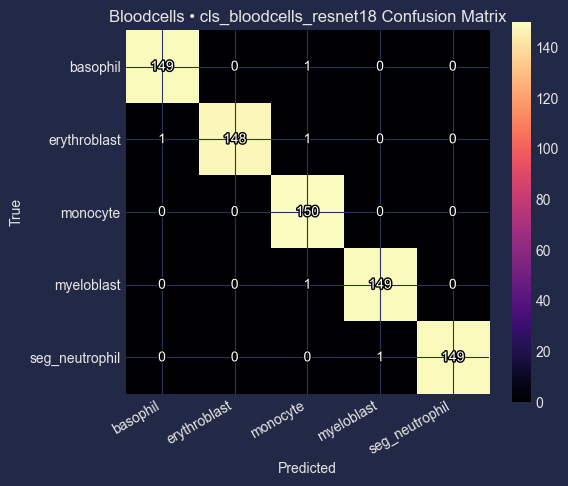

In [17]:
# CNN (ResNet-18)
test_and_report_from_ckpt(
    REPO_ROOT / "checkpoints" / "classification" / "cls_bloodcells_resnet18.pt",
    build_model_fn=build_resnet18,
    tag="cls_bloodcells_resnet18",
    test_loader=test_loader,
    device=device,
    default_class_names=class_names
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24532\2339558120.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


  0%|          | 0/24 [00:00<?, ?it/s]

[cls_bloodcells_vit_tiny_patch16_224]  Test Accuracy: 0.9907 | Macro AUROC: 0.9985

                precision    recall  f1-score   support

      basophil     1.0000    0.9667    0.9831       150
  erythroblast     1.0000    0.9933    0.9967       150
      monocyte     0.9615    1.0000    0.9804       150
    myeloblast     0.9934    1.0000    0.9967       150
seg_neutrophil     1.0000    0.9933    0.9967       150

      accuracy                         0.9907       750
     macro avg     0.9910    0.9907    0.9907       750
  weighted avg     0.9910    0.9907    0.9907       750

Saved → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\metrics\cls_bloodcells_vit_tiny_patch16_224_test.json


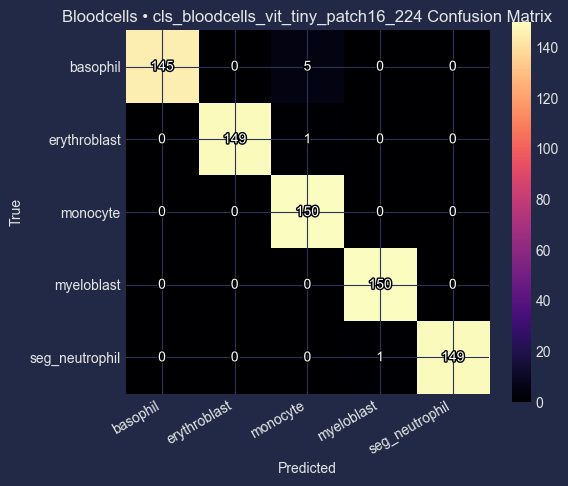

In [20]:
def build_vit_tiny(num_classes, name="vit_tiny_patch16_224"):
    import timm
    return timm.create_model(name, pretrained=False, num_classes=num_classes)

vit_name = "vit_tiny_patch16_224"

test_and_report_from_ckpt(
    REPO_ROOT / "checkpoints" / "classification" / f"cls_bloodcells_{vit_name}.pt",
    build_model_fn=lambda n: build_vit_tiny(n, name=vit_name),   # <-- ViT builder
    tag=f"cls_bloodcells_{vit_name}",
    test_loader=test_loader,
    device=device,
    default_class_names=class_names
)
